In [1]:
import tensorflow as tf
from tensorflow import keras
from keras_self_attention import SeqSelfAttention


print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices()))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)


Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


In [2]:
import numpy as np
import pandas as pd

import re #regex
import matplotlib.pyplot as plt

import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout,  LSTM, Dense, Embedding, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import Adam
import io
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('brown')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.utils import to_categorical


stepsize = 10
map_fn = tf.map_fn

from livelossplot.inputs.tf_keras import PlotLossesCallback

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

from nltk.corpus import brown
word_list = brown.words()
word_set = set(word_list)
word_set = [word.lower() for word in word_set]

from gensim.models import Word2Vec
import pickle

from tensorflow.keras import backend as K

from rouge import Rouge #https://towardsdatascience.com/introduction-to-text-summarization-with-rouge-scores-84140c64b471
ROUGE = Rouge()
import copy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\yanie\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
buffer_size = 10000
batch_size= 256
emb_dim=300 #The dimensionality of our embeddings
window_size= 40 
num_epoch =20000
epochs= 150
stop_words_list = stopwords.words('english') 
TRAIN_AND_SAVE = False
TRAIN_AND_SAVE_TRANFORMER = False

TRAIN_TEXT= True
SEED=42
TRAIN_TOKEN = True
GENERATE_TEXT= True

import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('..\cc.en.300.bin')
fasttext.util.reduce_model(ft, emb_dim)
ft.get_dimension()

ft_pt = fasttext.load_model('..\cc.pt.300.bin')

translationTable = str.maketrans("áéíóúàèìòùâêîôûãõç", "aeiouaeiouaeiouaoc")

In [5]:
def prepare_data(path_to_file ='./nietzsche.txt'):
    path_to_file = "./eca_de_queiros_os_maias.txt"
    
    with io.open(path_to_file, encoding='utf-8') as f:
        text = f.read().lower()

    print('corpus length:', len(text))
    text = text.translate(translationTable)

    string_check= re.compile('[^a-zA-Z.?!,:\'<>]')

    text = re.sub(string_check, ' ', (text)
                        .replace("-"," ")
                        .replace("´","'")
                        .replace("`","'")
                        .replace(","," , ")
                        .replace("s."," sao ")
                        .replace("d.","don")
                        .replace("v.","v")
                        .replace("sr.", "senhor")
                        .replace("sra.", "senhora")
                        .replace("exmo.", "exmo")
                        .replace("exma.", "exma")
                        .replace("x.", "x")
    )

    text = re.sub(' +', ' ',text)
    text = (re.sub('\.+', " . <EOS>  <SOS>", text).replace("?"," ? <EOS>  <SOS>").replace("!"," !  <EOS>  <SOS>").replace(":"," : ").replace("<br />"," "))

    lines_list = list()

    text = "<SOS> " +text
    lines_list = text.split("<EOS>  <SOS>")

    for i in range(len(lines_list)):
        if i == 0:
            lines_list[i] += " <EOS> "
        else:
            lines_list[i] = "<SOS> "+ lines_list[i]+" <EOS>"

    cols = ['sentences']
    df_tmp= pd.DataFrame(columns=cols)
    df_tmp["sentences"] = lines_list

    return df_tmp


In [6]:

def tokenize_dataset(text):

    """****************************************************************************
    Convert the word selected to train word embeddings into tokenized vector to pass to embedding layer 
    ******************************************************************************"""
    tokenizer = Tokenizer(filters='', lower=True, split=' ', char_level=False, oov_token="<oov>")
    tokenizer.fit_on_texts(text.split())
    
    sequences = tokenizer.texts_to_sequences(text.split()) # All the corpus text integer index
    
    word_index = tokenizer.word_index
    vocab_len = len(word_index) + 1  
    print("vocab_len : ",vocab_len)

        
    return tokenizer, word_index, vocab_len,sequences 


def tokenize_dataset_tokens(text_wind):

    """****************************************************************************
    Convert the word selected to train word embeddings into tokenized vector to pass to embedding layer 
    ******************************************************************************"""
    tokenizer = Tokenizer(filters='"#$%&()*+-/=@[\\]^_´`«»{|}~\t\n',oov_token='<oov>')# sequence_size = 500 ~= mean+ std sentence size
    tokenizer.fit_on_texts(text_wind)
    
    sequences = tokenizer.texts_to_sequences(text_wind) # All the corpus text integer index
    
    word_index = tokenizer.word_index
    vocab_len = len(word_index) + 1  
    print("vocab_len : ",vocab_len)
        
    return tokenizer, word_index, vocab_len,sequences


def get_embeddings_fb(ft_tmp,vocab):
    embeddings_matrix = np.zeros((vocab_len,emb_dim))
    for word in vocab:
        embeddings_matrix[vocab[word],:] = [float(i) for i in ft_tmp.get_word_vector(word)]
    
    return embeddings_matrix


In [7]:
if TRAIN_TEXT:
    df= prepare_data()
    tokenizer, word_index, vocab_len,sequences = tokenize_dataset_tokens(' '.join(df.sentences.tolist()).split())
    
if TRAIN_TOKEN:   
    with open('./checkpoints/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./checkpoints/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

df

corpus length: 1266856
vocab_len :  19344


,sentences
0,"<SOS> a casa que vieram habitar em lisboa , no..."
1,<SOS> apesar deste fresco nome de vivenda cam...
2,<SOS> longos anos o ramalhete permanecera des...
3,"<SOS> em monsenhor bucarini , nuncio de sao s..."
4,<SOS> este inutil pardieiro como lhe chamava ...
...,...
14586,<SOS> e foi em carlos e em joao da ega uma es...
14587,<SOS> ainda o apanhamos ! <EOS>
14588,"<SOS> de novo a lanterna deslizou , e fugiu ...."
14589,"<SOS> entao , para apanhar o americano , os d..."


,sentences,sent_length
0,"<SOS> a casa que vieram habitar em lisboa , no...",44
1,<SOS> apesar deste fresco nome de vivenda cam...,132
3,"<SOS> em monsenhor bucarini , nuncio de sao s...",214
4,<SOS> este inutil pardieiro como lhe chamava ...,66
5,<SOS> nessa ocasiao vendera se outra propried...,55
...,...,...
14534,<SOS> carlos pos tambem o chapeu : e descera...,99
14545,"<SOS> mas carlos queria realmente saber se , ...",51
14556,"<SOS> tudo aceitar , o que vem e o que foge ,...",63
14560,<SOS> se me dissessem que ali em baixo estava...,43


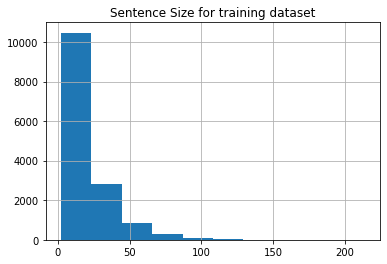

In [8]:
df["sent_length"] = df.sentences.apply(lambda x: len(x.split()))

plt.figure()
pd.Series(df.sent_length).hist()
plt.title("Sentence Size for training dataset")
df[df.sent_length>window_size]

In [9]:
inputs = []
outputs = [] 
count = 0
for it, sent in enumerate(df.sentences.tolist()):
    sentence_lists = sent.split()
    if len(sentence_lists) > window_size:
        for i in range(0, len(sentence_lists)-window_size,1):
            inputs.append(sentence_lists[i: window_size+i])
            outputs.append(sentence_lists[i+1: window_size+i+1])
            count +=1
    else:
        inputs.append(sentence_lists[:-1])
        outputs.append(sentence_lists[1:])

    if len(inputs)>30000  :
        break

len(inputs), len(outputs), it

(30048, 30048, 8231)

In [10]:
input_sequence = tokenizer.texts_to_sequences(inputs)
output_sequence = tokenizer.texts_to_sequences(outputs)

In [11]:
for i in range(3):
    print(f"INPUT {i} : " + ' '.join(inputs[i]))
    print(f"OUTPUT {i} : " + ' '.join(outputs[i]))
    print()

INPUT 0 : <SOS> a casa que vieram habitar em lisboa , no outono de , era conhecida na vizinhanca da rua de sao francisco de paula , e em todo o bairro das janelas verdes , pela casa do ramalhete ou simplesmente
OUTPUT 0 : a casa que vieram habitar em lisboa , no outono de , era conhecida na vizinhanca da rua de sao francisco de paula , e em todo o bairro das janelas verdes , pela casa do ramalhete ou simplesmente o

INPUT 1 : a casa que vieram habitar em lisboa , no outono de , era conhecida na vizinhanca da rua de sao francisco de paula , e em todo o bairro das janelas verdes , pela casa do ramalhete ou simplesmente o
OUTPUT 1 : casa que vieram habitar em lisboa , no outono de , era conhecida na vizinhanca da rua de sao francisco de paula , e em todo o bairro das janelas verdes , pela casa do ramalhete ou simplesmente o ramalhete

INPUT 2 : casa que vieram habitar em lisboa , no outono de , era conhecida na vizinhanca da rua de sao francisco de paula , e em todo o bairro das janelas v

In [12]:
tokenizer.index_word

{1: '<oov>',
 2: ',',
 3: '<sos>',
 4: '<eos>',
 5: '.',
 6: 'de',
 7: 'a',
 8: 'o',
 9: 'e',
 10: 'que',
 11: 'um',
 12: 'se',
 13: '!',
 14: 'com',
 15: 'do',
 16: 'sao',
 17: 'uma',
 18: 'da',
 19: 'nao',
 20: 'os',
 21: 'para',
 22: 'as',
 23: ':',
 24: 'carlos',
 25: 'em',
 26: 'no',
 27: 'lhe',
 28: 'ao',
 29: '?',
 30: 'na',
 31: 'ega',
 32: 'como',
 33: 'por',
 34: 'ele',
 35: 'era',
 36: 'mas',
 37: 'seu',
 38: 'mais',
 39: 'sua',
 40: 'ela',
 41: 'ja',
 42: 'dos',
 43: 'muito',
 44: 'la',
 45: 'eu',
 46: 'depois',
 47: 'senhor',
 48: 'me',
 49: 'entao',
 50: 'sobre',
 51: 'das',
 52: 'tinha',
 53: 'nos',
 54: 'esta',
 55: 'maria',
 56: 'quando',
 57: 'ainda',
 58: 'sem',
 59: 'num',
 60: 'foi',
 61: 'damaso',
 62: 'tudo',
 63: 'disse',
 64: 'onde',
 65: 'numa',
 66: 'estava',
 67: 'bem',
 68: 'agora',
 69: 'so',
 70: 'tao',
 71: 'seus',
 72: 'entre',
 73: 'grande',
 74: 'tambem',
 75: 'casa',
 76: 'dum',
 77: 'afonso',
 78: 'olhos',
 79: 'todo',
 80: 'logo',
 81: 'vilaca',
 8

In [13]:
' '.join([tokenizer.index_word[w] for w in output_sequence[1]])

'casa que vieram habitar em lisboa , no outono de , era conhecida na vizinhanca da rua de sao francisco de paula , e em todo o bairro das janelas verdes , pela casa do ramalhete ou simplesmente o ramalhete'

In [14]:
candidate_list=['data scientist tasks', 'data scientist jobs','data scientist job','data scientist, and','data engineer tasks','data engineer jobs']

def Minimum_Bayes_Risk(list_of_candidates, field = "rouge-l", candidate_reference = None):
    candidate_score = {}
    max_score = 0
    best_score_candidate= ''
    best_candidate_index = -1
    if candidate_reference == None :
        for candidate_ref in list_of_candidates:
            
            rest_of_candidates = copy.deepcopy(list_of_candidates)
            if candidate_ref in rest_of_candidates : rest_of_candidates.remove(candidate_ref)
            score = 0

            for candidate in rest_of_candidates:
                score += ROUGE.get_scores(candidate, candidate_ref)[0][field]["f"]
            
            score = score/len(rest_of_candidates)

            candidate_score[candidate_ref] = score

            if score >= max_score:
                best_score_candidate =candidate_ref
                best_candidate_index = list_of_candidates.index(candidate_ref)
                max_score = score

    else:
            
            for candidate in list_of_candidates:
                score = 0
                score = ROUGE.get_scores(candidate, candidate_reference)[0][field]["f"]
                if score >= max_score:
                    best_score_candidate =candidate_ref


    return candidate_score, best_score_candidate, best_candidate_index

candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(candidate_list)
candidate_score, best_score_candidate , best_candidate_index

({'data scientist tasks': 0.5333333283333335,
  'data scientist jobs': 0.5333333283333335,
  'data scientist job': 0.4666666616666668,
  'data scientist, and': 0.3333333283333334,
  'data engineer tasks': 0.4666666616666667,
  'data engineer jobs': 0.4666666616666667},
 'data scientist jobs',
 1)

In [15]:
x = pad_sequences(input_sequence, padding='post', maxlen=window_size)#post
y = pad_sequences(output_sequence, padding='post', maxlen=window_size)
dataset = tf.data.Dataset.from_tensor_slices((x,y))
for x,y in dataset.take(3):
    print("Input : ",x.numpy(), " ->",x.numpy().shape)
    print("Output : ",y.numpy(), " ->",y.numpy().shape,"\n\n")
    
    
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
print("Batched dataset ... \n")
for x,y in dataset.take(1):
    print("Input : ",x)
    print("Output : ",y,"\n\n")

ds_len = len(list(dataset))
val_size = int(0.07 * ds_len)
val_dataset = dataset.take(val_size) 
train_dataset = dataset.skip(val_size)

train_size = len(list(train_dataset))

dataset = dataset.repeat()
train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

print(ds_len,"-->",train_size,"--->",val_size,"/",ds_len*batch_size)

dataset = train_dataset
ds_len = train_size



Input :  [   3    7   75   10 2084 2285   25  135    2   26 1083    6    2   35
 2496   30 2813   18  160    6   16  371    6 7027    2    9   25   79
    8 1084   51  425 1801    2   82   75   15  155   93  735]  -> (40,)
Output :  [   7   75   10 2084 2285   25  135    2   26 1083    6    2   35 2496
   30 2813   18  160    6   16  371    6 7027    2    9   25   79    8
 1084   51  425 1801    2   82   75   15  155   93  735    8]  -> (40,) 


Input :  [   7   75   10 2084 2285   25  135    2   26 1083    6    2   35 2496
   30 2813   18  160    6   16  371    6 7027    2    9   25   79    8
 1084   51  425 1801    2   82   75   15  155   93  735    8]  -> (40,)
Output :  [  75   10 2084 2285   25  135    2   26 1083    6    2   35 2496   30
 2813   18  160    6   16  371    6 7027    2    9   25   79    8 1084
   51  425 1801    2   82   75   15  155   93  735    8  155]  -> (40,) 


Input :  [  75   10 2084 2285   25  135    2   26 1083    6    2   35 2496   30
 2813   18  160    6

In [16]:
embeddings_matrix=get_embeddings_fb(ft_pt,word_index)
train_size = len(input_sequence) //batch_size

# Training

In [17]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence, figsize  =(10, 10)):
  sentence = sentence.split()
  predicted_sentence = predicted_sentence.split() + ['<eos>']
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')
  
  
def plot_weights(res, stop_time = 3, loop = True):

    if loop :
        for t in range(len(res["input_text"])):
        
            plt.figure()
            attention_array = np.array(res["attention"][t])
            _ = plt.bar(range(len(attention_array[0, :])), attention_array[t, :])
            
            plt.figure()

            plot_attention(res['attention'][t],  res["output_text"][t],  res["output_text"][t])#input_text
            plt.show()

            if t == stop_time:
                break
    else:
        t = -1
        attention_array = np.array(res["attention"][t])
        plt.figure()

        plot_attention(res['attention'][t],  res["output_text"][t],  res["output_text"][t])#input_text
        plt.show()


In [18]:
class MaskedLossCustom(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_custom'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)


def perplexity(labels, logits):
    #Calculates perplexity metric = 2^(entropy) or e^(entropy)
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    return pow(2, loss(y_true=labels, y_pred=logits))



class SelfMaskedDotProductAttention(tf.keras.Model): 
    def __init__(self):
        super(SelfMaskedDotProductAttention, self).__init__()


    def call(self, q, k, v, padding_mask= None, look_ahead_mask= None):
        
        PRINT_SHAPE= False
                
        matmul_qk = tf.matmul(q, k, transpose_b=True) 

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        if PRINT_SHAPE : print("weight shape : ", scaled_attention_logits.shape," - [batch_size, Tq, Tv]")
        
        if padding_mask is not None:
            padding_mask = tf.expand_dims(padding_mask, 1)
            scaled_attention_logits = tf.where(padding_mask, scaled_attention_logits, tf.experimental.numpy.full_like(scaled_attention_logits,  -1e9))
            

        if look_ahead_mask is not None:
            scaled_attention_logits += (look_ahead_mask * -1e9)
            

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
        if PRINT_SHAPE : print("attention_weights / values : ",attention_weights.shape, v.shape)

        context_vector = tf.matmul(attention_weights, v)

        if PRINT_SHAPE : print("context_vector shape : ", context_vector.shape)

        return context_vector, attention_weights



class TextModel(tf.keras.Model):
    def __init__(self, vocab_len, emb_dim,embeddings_matrix, causal_mask_enabled=0, blstm_enable = False, use_attention= True):
        super(TextModel, self).__init__()
        
        self.causal_mask_enabled = causal_mask_enabled
        self.blstm_enable = blstm_enable
        self.use_attention = use_attention
        self.units = emb_dim#256
        if blstm_enable:
            self.dot_attention = SelfMaskedDotProductAttention()
            self.blstm = Bidirectional(LSTM(self.units, return_sequences=True, return_state = True))
        else:
            self.dot_attention = SelfMaskedDotProductAttention()
            self.lstm = LSTM(self.units, return_sequences=True, return_state = True)
        
        self.emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)
        self.dense0 = Dense(256, activation='relu') 
        self.dense1 = Dense(vocab_len) #, activation='softmax'
        self.drop0 = tf.keras.layers.Dropout(0.5)
        self.batchNorm1 =BatchNormalization()


    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)
    
    def call(self, inputs, last_attention =None, last_state= None, input_mask = None, last_activation = None):
        
        x = self.emb_layer(inputs)

        if last_state is None:
            if self.blstm_enable:
                last_state = [tf.zeros((len(x), self.units)) for i in range(4)]
            else:
                last_state = self.lstm.get_initial_state(x)
        
        if last_activation is None:
            if self.blstm_enable:
                last_activation = tf.zeros((len(x),inputs.shape[1],self.units*2))
            else:
                last_activation = tf.zeros((len(x),inputs.shape[1],self.units))
        
       
        if self.blstm_enable:
            lstm_out, h_state, c_state, h_state2, c_state2 = self.blstm(x, initial_state=last_state )
        else:
            lstm_out, h_state, c_state = self.lstm(x, initial_state=last_state ) 

        if self.causal_mask_enabled == 0 :
            look_ahead_mask = None
        else:
            look_ahead_mask = self.create_look_ahead_mask(tf.shape(inputs)[1])

        if self.use_attention:
            context_vector, attention_weights = self.dot_attention(lstm_out, lstm_out, lstm_out, input_mask, look_ahead_mask)
            x= context_vector
            
        else :
            context_vector = None
            attention_weights = None
            x = lstm_out
            
        x = self.batchNorm1(x)
        x = self.dense0(x)
        pred = self.dense1(x)
        
        if self.blstm_enable:
            return pred, (h_state, c_state, h_state2, c_state2), attention_weights, lstm_out , context_vector 
        else:
            return pred, (h_state, c_state), attention_weights, lstm_out, context_vector 



In [19]:

class ModelClass(tf.keras.Model):
    def __init__(self, vocab_len, model_type= 1, causal_mask_enabled= 0 , blstm_enable = False, loop= True, use_attention= True):
        super(ModelClass, self).__init__()
        self.vocab_size = vocab_len
        self.loop = loop
        self.textModel = TextModel(vocab_len, emb_dim,embeddings_matrix, causal_mask_enabled, blstm_enable, use_attention)

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            if self.loop:
                return self._train_step_loop(inputs)
            else:
                return self._train_step(inputs)


    def _train_step(self, inputs):
        inp, targ = inputs  
        target_mask = targ != 0     
        last_state= None
        last_activation = None
        last_attention = None

        with tf.GradientTape() as tape:
            loss = tf.constant(0.0)
            acc = []
            x = inp
            input_mask = x != 0
            y =  targ
            
            pred, last_state , attention_weights, last_activation, last_attention  = self.textModel(x, last_attention, last_state, input_mask, last_activation)
            
            loss += self.loss(y, pred)
            self.compiled_metrics.update_state(y, pred)
            acc.append(self.metrics[0].result())

            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
            average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
            average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(y, pred) ))
            
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        m = {m.name: average_acc   for m in self.metrics}
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
    
        return m
    
    def call(self, inputs, last_attention = None, last_state = None,  last_activation  = None):
        input_mask = inputs != 0
        pred, last_state , attention_weights, last_activation, last_attention  = self.textModel(inputs, last_attention, last_state, input_mask, last_activation)

        return pred, last_state , attention_weights, last_activation, last_attention

    def _train_step_loop(self, inputs):
        inp, targ = inputs  
        
        target_mask = targ != 0     

        last_state= None
        last_activation = None
        last_attention = None
        
        with tf.GradientTape() as tape:
            loss = tf.constant(0.0)
            acc = []
            x = inp
            perplexity_list = []
            y =  targ
            for t in range(0, targ.shape[1]):
                
                dec_input = tf.expand_dims(x[:, t], 1)## Teacher forcing - feeding the target as the next input
                input_mask = dec_input != 0
                
                pred, last_state , attention_weights, last_activation, last_attention = self.textModel(dec_input,  last_attention, last_state, input_mask, last_activation)
                
                tar = tf.expand_dims(y[:, t], 1)
                loss += self.loss(tar, pred)

                self.compiled_metrics.update_state(tar, pred)
                acc.append(self.metrics[0].result())
                perplexity_list.append(perplexity(tar, pred))


            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
            average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
            
            average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity_list))
            
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        m = {m.name: average_acc   for m in self.metrics}
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
    
        return m
            

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])#
                                
    def _tf_train_step(self, inputs):
        if self.loop:
            return self._train_step_loop(inputs)
        else:
            return self._train_step(inputs)


    def test_step(self, inputs):
        if self.use_tf_function:
            return self._tf_test_step(inputs)
        else:
            if self.loop:
                return self._test_step_loop(inputs)
            else:
                return self._test_step(inputs)

    
    def _test_step(self, inputs):
        inp, targ = inputs  
        
        target_mask = targ != 0
        input_mask = None

        loss_val = tf.constant(0.0)
        acc = []

        last_state= None
        last_activation = None
        last_attention = None

        x = inp
        y =  targ
        input_mask = x != 0
        
        pred, last_state , attention_weights, last_activation, last_attention  = self.textModel(x, last_attention, last_state, input_mask, last_activation)
        
        loss_val += self.loss(y, pred)

        self.compiled_metrics.update_state(y, pred)
        acc.append(self.metrics[0].result())
        

        average_loss = loss_val / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
        average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
        average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(y, pred) ))

        m = {m.name: average_acc  for m in self.metrics}
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        
        return m

    def _test_step_loop(self, inputs):
        inp, targ = inputs  
        
        target_mask = targ != 0
        input_mask = None

        loss_val = tf.constant(0.0)
        acc = []

        last_state= None
        last_activation = None
        last_attention = None

        x = inp
        perplexity_list = []
        y =  targ
        
        for t in range(0, targ.shape[1]):
            
            dec_input = tf.expand_dims(x[:, t], 1)## Teacher forcing - feeding the target as the next input
            input_mask = dec_input != 0

            pred, last_state , attention_weights, last_activation, last_attention = self.textModel(dec_input,  last_attention, last_state, input_mask, last_activation)
            
            tar = tf.expand_dims(y[:, t], 1)
            loss_val += self.loss(tar, pred)
            self.compiled_metrics.update_state(tar, pred)
            acc.append(self.metrics[0].result())
            perplexity_list.append(perplexity(tar, pred))
            acc.append(self.metrics[0].result())

        average_loss = loss_val / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
        average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
        average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity_list))

        m = {m.name: average_acc  for m in self.metrics}
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        
        return m


    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])
                                ]])
    def _tf_test_step(self, inputs):
        if self.loop:
            return self._test_step_loop(inputs)
        else:
            return self._test_step(inputs)

In [20]:
if TRAIN_AND_SAVE:
    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix)
    for i, o in dataset.take(1):
        print(i.shape, o.shape)
        text_model(i)

    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix, causal_mask_enabled= 1)
    for i, o in dataset.take(1):
        text_model(i)


    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix, causal_mask_enabled= 2)
    for i, o in dataset.take(1):
        text_model(i)

    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix, blstm_enable= True)
    for i, o in dataset.take(1):
        text_model(i)

    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix, causal_mask_enabled= 1,  blstm_enable= True)
    for i, o in dataset.take(1):
        text_model(i)

    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix, causal_mask_enabled= 2,  blstm_enable= True)
    for i, o in dataset.take(1):
        text_model(i)

    text_model = TextModel(vocab_len, emb_dim, embeddings_matrix, causal_mask_enabled= 2,  blstm_enable= True, use_attention = False)
    for i, o in dataset.take(1):
        text_model(i)

tf.Tensor(
[[   14     8  4730 ...  4731     8  3420]
 [    3    80    82 ...     9    22  1856]
 [    2  5554     2 ...     7   792  4545]
 ...
 [   87    46    15 ...     2  2655    12]
 [   39 12494   270 ...     2   207    18]
 [    3    96   421 ...     0     0     0]], shape=(256, 40), dtype=int32)


Text(0.5, 1.0, 'Attention weights causal')

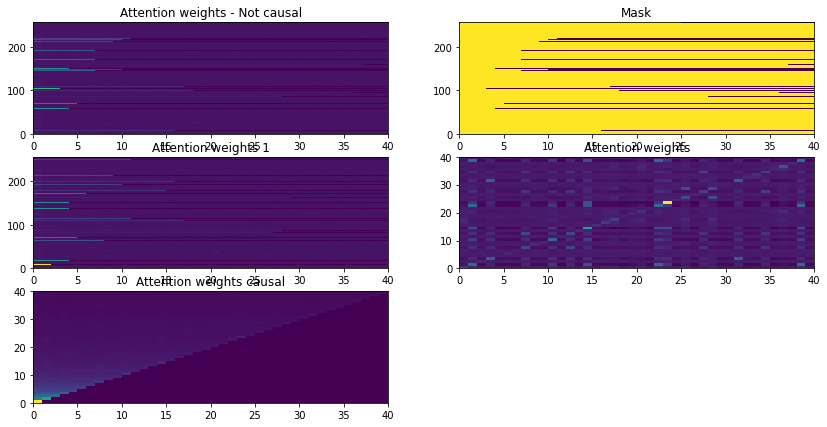

In [23]:
for i, o in dataset.take(1):
    print(i)
    
emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)

attention_layer = SelfMaskedDotProductAttention()
attention_layer_causal1 = SelfMaskedDotProductAttention()
#attention_layer_causal2 = SelfMaskedDotProductAttention(causal_mask_enabled=2)

emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=emb_dim, weights=[embeddings_matrix] ,name ="emb_layer", trainable=False, mask_zero = True)
query = emb_layer(i)
values = emb_layer(i)

context_vector, attention_weights = attention_layer(query,values,values, (i != 0))
context_vector1, attention_weights1 = attention_layer_causal1(query,values,values, (i != 0))
context_vector1, attention_weights_causal = attention_layer_causal1(query,values,values, (i != 0), (1 - tf.linalg.band_part(tf.ones((i.shape[1], i.shape[1])), -1, 0)))



plt.figure(figsize=(14,7))
plt.subplot(3, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights - Not causal')

plt.subplot(3, 2, 2)
plt.pcolormesh(i != 0)
plt.title('Mask')

plt.subplot(3, 2, 3)
plt.pcolormesh(attention_weights1[:, 0, :])
plt.title('Attention weights 1')

plt.subplot(3, 2, 4)
plt.pcolormesh(attention_weights[0])
plt.title('Attention weights')

plt.subplot(3, 2, 5)
plt.pcolormesh(attention_weights1[0])
plt.title('Attention weights 1')

plt.subplot(3, 2, 5)
plt.pcolormesh(attention_weights_causal[0])
plt.title('Attention weights causal')

In [ ]:
blstm_enable = False

if TRAIN_AND_SAVE:
    model = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 0, blstm_enable=blstm_enable, use_attention=False)
    model.compile(loss=MaskedLossCustom(), optimizer=Adam(learning_rate=0.0005), metrics=[tf.metrics.SparseCategoricalAccuracy()])

    model_causal1 = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 1, blstm_enable=blstm_enable, loop= False)
    model_causal1.compile(loss=MaskedLossCustom(), optimizer=Adam(learning_rate=0.0005), metrics=[tf.metrics.SparseCategoricalAccuracy()])


In [ ]:
vocab_size = vocab_len
token_mask_ids = np.array([tokenizer.word_index[x] for x in  [ '<oov>', '<eos>' ]])[:, None]#
token_mask = np.zeros([vocab_size], dtype=np.bool)
token_mask[np.array(token_mask_ids)] = True

print("token_mask", token_mask)
def generate_sentence(model_inst, input_tokens, max_length=10, temperature=1, number_of_candidates = 20, no_state = False, loop= False):
    
    
    attention_per_candidate = []
    result_text_per_candidate = []
    input_text_per_candidate = []
    output_text_per_candidate = []

    for c in range(number_of_candidates):

        last_state= None
        last_activation = None
        input_mask = None
        last_attention = None

        result_tokens = []
    
        attention = []

        x = input_tokens
        input_text= []
        output_text = []
        result_tokens = [w.numpy() for w in  x[0] if w != 0 ]
        for k in range(max_length):

            input_text.append(' '.join([tokenizer.index_word[w.numpy()] for w in  x[0] if w != 0 ]))
            x = pad_sequences(x, padding = "post", maxlen = window_size)#

            input_mask = x!= 0
            t = np.count_nonzero(input_mask)

            if no_state: last_state= None

            predictions, last_state , attention_weights, last_activation, last_attention  =model_inst(x, last_attention, last_state,  last_activation)

            if k > 0 and attention_weights is not None:
                attention.append(attention_weights[0])

            predicted_logits  = predictions[:,t-1,:]/temperature
            predicted_logits = tf.where(token_mask, -np.inf, predicted_logits)
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            new_tokens = tf.squeeze(predicted_ids, axis=-1)

            if loop:
            
                x = new_tokens.numpy()
            else : 

                x = list(x[0])
                x = [i for i in x if i != 0]
                x.append(new_tokens.numpy()[0])
                

            output_text.append(' '.join([tokenizer.index_word[w] for w in  x if w != 0 ][1:]))
            x = tf.reshape(tf.convert_to_tensor(x), (len(input_tokens),len(x)))
            result_tokens.append(new_tokens.numpy()[0])
                
            if tokenizer.word_index['<eos>'] == new_tokens.numpy()[0]:
                break


        result_text =   ' '.join([tokenizer.index_word[w] for w in  result_tokens if w != 0 ])
        
        attention_per_candidate.append(attention)
        result_text_per_candidate.append(result_text)
        input_text_per_candidate.append(input_text)
        output_text_per_candidate.append(output_text)

    candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(result_text_per_candidate)

    attention_stack = attention_per_candidate[best_candidate_index]
    result_text = result_text_per_candidate[best_candidate_index]
    input_text = input_text_per_candidate[best_candidate_index]
    output_text = output_text_per_candidate[best_candidate_index]
    
    return {'generated_text': result_text, 'attention': attention_stack, "input_text" : input_text, "output_text" : output_text, "candidates": result_text_per_candidate}



token_mask [False  True False ... False False False]


C:\Users\yanie\AppData\Local\Temp\ipykernel_19468\1393128631.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([vocab_size], dtype=np.bool)


In [ ]:
if TRAIN_AND_SAVE:
    input_sent = "<sos> eu quero "
    inp_seq = np.array([tokenizer.word_index[x] for x in input_sent.split()])
    print("inp_seq -->",inp_seq)

    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0),max_length= 5)
    print("RESULT : ",result["generated_text"])
    plot_weights(result, stop_time = 3, loop=True)

    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0),max_length= 5, loop=True)


In [ ]:
if TRAIN_AND_SAVE:
    model.use_tf_function = False
    for i, o in dataset.take(2):
        print(model.train_step([i, o]))
        print(model.test_step([i, o]))
    print()

    model_causal1.use_tf_function = False
    for i, o in dataset.take(2):
        print(model_causal1.train_step([i, o]))
        print(model_causal1.test_step([i, o]))
    print()

    print("\n---------------------\n")

    model.use_tf_function = True
    for i, o in dataset.take(2):
        print(model.train_step([i, o]))
        print(model.test_step([i, o]))
    print()

    model_causal1.use_tf_function = True
    for i, o in dataset.take(2):
        print(model_causal1.train_step([i, o]))
        print(model_causal1.test_step([i, o]))

    print()
    

Loading saved data ...


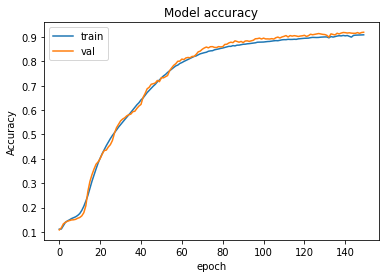

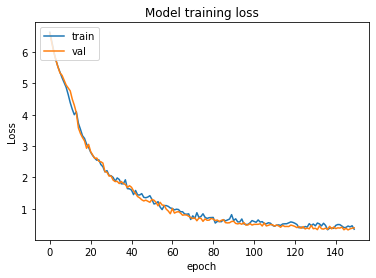

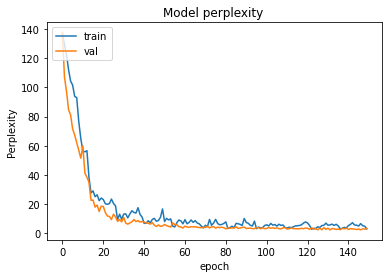

In [ ]:
if TRAIN_AND_SAVE:
    
    history = model.fit(dataset, epochs=epochs, shuffle= True,#6000
                        steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    model.save_weights("./checkpoints/model_ckpt")

    with open('./checkpoints/history.pickle', 'wb') as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else :
    print("Loading saved data ...")
    model = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 0, blstm_enable=blstm_enable, use_attention=False)
    model.load_weights("./checkpoints/model_ckpt")

    with open('./checkpoints/history.pickle', 'rb') as handle:
        history = pickle.load(handle)
        plt.figure()
        plt.plot(history['sparse_categorical_accuracy'])
        plt.plot(history['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history['perplexity'])
        plt.plot(history['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()
 

Loading saved data ...


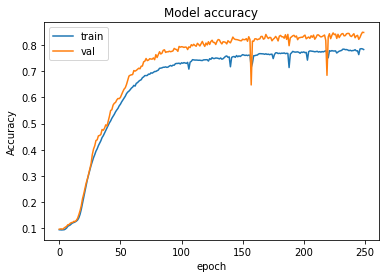

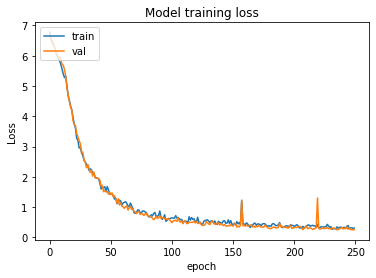

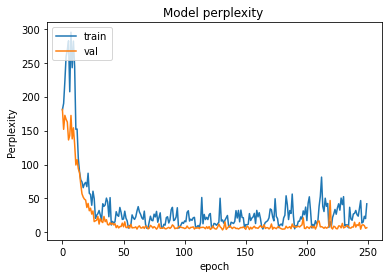

In [ ]:
if TRAIN_AND_SAVE:
    
    history_causal1 = model_causal1.fit(dataset, epochs=epochs+100, shuffle= True, #6000
                        steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    model_causal1.save_weights("./checkpoints/model_causal1_ckpt")

    with open('./checkpoints/history_causal1.pickle', 'wb') as handle:
        pickle.dump(history_causal1.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else :
    print("Loading saved data ...")
    model_causal1 = ModelClass(vocab_len, model_type=1, causal_mask_enabled= 1, blstm_enable=blstm_enable, loop= False)

    model_causal1.load_weights("./checkpoints/model_causal1_ckpt")

    with open('./checkpoints/history_causal1.pickle', 'rb') as handle:
        history_causal1 = pickle.load(handle)
        plt.figure()
        plt.plot(history_causal1['sparse_categorical_accuracy'])
        plt.plot(history_causal1['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_causal1['loss'])
        plt.plot(history_causal1['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_causal1['perplexity'])
        plt.plot(history_causal1['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()

# Transformer Decoder


In [ ]:
def scaled_dot_product_attention(q, k, v, padding_mask= None, look_ahead_mask= None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)


  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if padding_mask is not None:
    scaled_attention_logits += (padding_mask * -1e9)

  if look_ahead_mask is not None:
    scaled_attention_logits += (look_ahead_mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = Dense(d_model)
    self.wk = Dense(d_model)
    self.wv = Dense(d_model)

    self.dense = Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, padding_mask, look_ahead_mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention( q, k, v, padding_mask, look_ahead_mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
batch_size = 10
n_vectors = 150
d_model = 256

query = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
key = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
value = tf.random.uniform((batch_size, n_vectors, d_model), dtype=tf.float32)
query.shape, key.shape

(TensorShape([10, 150, 256]), TensorShape([10, 150, 256]))

In [ ]:
# Test dot product attention
x,_ = scaled_dot_product_attention(query, key, key, None)
print(f"Output from dot product attention: {x.shape}")

att = SelfMaskedDotProductAttention()
x1, _ = att(query, key,key)
#x = tf.concat(x, -1)
print(f"Output from dot product attention: {x1.shape}")
np.where((x-x1) > 0.1)

Output from dot product attention: (10, 150, 256)
Output from dot product attention: (10, 150, 256)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [ ]:
# Test multi-head attention
mh_layer = MultiHeadAttention(d_model=512, num_heads=8)
x, _ = mh_layer(query, key, value, None, None)
print(f"Output from multi-head attention: {x.shape}")

Output from multi-head attention: (10, 150, 512)


In [ ]:
def point_wise_feed_forward_network(d_model, dff): #Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
  return tf.keras.Sequential([
      Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, x, training, padding_mask= None, look_ahead_mask = None):
    attn_output, attn_weights_block1  = self.mha(x, x, x, padding_mask, look_ahead_mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2, attn_weights_block1


sample_encoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=batch_size)
sample_encoder_layer_output,attn_weights_block1 = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, vocab_len
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

(1, 2048, 19344)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, embeddings_matrix, window_size, num_heads, dff, vocab_len,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.emb_layer = Embedding(input_dim=vocab_len, input_length = window_size, output_dim=d_model, weights=[embeddings_matrix] ,name ="emb_layer2", trainable=False)#, mask_zero = True
    self.pos_encoding = positional_encoding(window_size, self.d_model)

    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, padding_mask =None, look_ahead_mask= None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.emb_layer(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1 = self.dec_layers[i](x, training, padding_mask, look_ahead_mask)
      attention_weights[f'decoder_layer{i+1}_block1'] = block1


    return x ,attention_weights # (batch_size, input_seq_len, d_model)

sample_decoder = Decoder(num_layers=2, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size= window_size, num_heads=10,
                         dff=2048, vocab_len=vocab_len)

for i, o in dataset.take(1):
  print(i.shape, o.shape)
  output, attn = sample_decoder(i, training=True, padding_mask =None, look_ahead_mask= None)
  
output.shape, attn['decoder_layer2_block1'].shape

(256, 40) (256, 40)


(TensorShape([256, 40, 300]), TensorShape([256, 10, 40, 40]))

In [ ]:
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_transformer_custom'
    self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  def __call__(self, real, pred):
      
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  real = tf.cast(real, dtype=tf.int32)
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
  

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



Text(0.5, 0, 'Train Step')

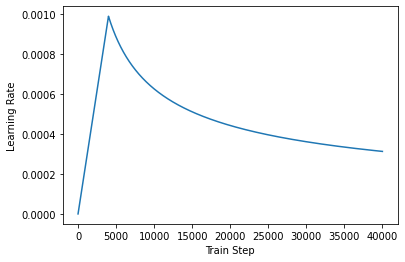

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model,embeddings_matrix,window_size, num_heads, dff,  vocab_len,rate=0.1, use_tf_function= False):
        super().__init__()

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, embeddings_matrix = embeddings_matrix,
                            window_size= window_size, num_heads=num_heads, dff=dff, vocab_len=vocab_len, rate=rate)

        self.final_layer = Dense(vocab_len)
        self.use_tf_function = use_tf_function

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp = inputs

        padding_mask, look_ahead_mask = self.create_masks(inp)
        
        # dec_output.shape == (batch_size, inp_seq_len, d_model)
        dec_output, attention_weights = self.decoder(inp, training, padding_mask, look_ahead_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, vocab_len)

        return final_output, attention_weights

    def create_masks(self, inp):
        # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
        
        padding_mask = self.create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(inp)[1])

        return padding_mask, look_ahead_mask

    def create_padding_mask(self,seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        # add extra dimensions to add the padding
        # to the attention logits.
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (seq_len, seq_len)

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])
                                
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)



    def test_step(self, inputs):
        if self.use_tf_function:
            return self._tf_test_step(inputs)
        else:
            return self._test_step(inputs)


    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None, window_size]),
                                tf.TensorSpec(dtype=tf.int32, shape=[None, window_size])]])
    def _tf_test_step(self, inputs):
        return self._test_step(inputs)


    def _train_step(self, inputs):
        inp, tar = inputs
        target_mask = tar != 0     
        
        with tf.GradientTape() as tape:
            acc = []
            loss = tf.constant(0.0)

            predictions, _ = self.call(inp,training = True)
            loss += self.loss(tar, predictions)
            self.compiled_metrics.update_state(tar, predictions)

            acc.append(self.metrics[0].result())

            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
            average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
            average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(tar, predictions) ))
            average_cc  = tf.reduce_mean(tf.convert_to_tensor(accuracy_function(tf.cast(tar, tf.int32), predictions) ))

        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        m = {m.name: average_acc  for m in self.metrics} #.update({'loss': batch_loss})m.result() 
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        m["custom_acc"] = average_cc

        return m

    def _test_step(self, inputs):
        inp, tar = inputs
        target_mask = tar != 0     

        acc = []
        loss = tf.constant(0.0)

        predictions, _ = self.call(inp,training = True)
        loss += self.loss(tar, predictions)
        self.compiled_metrics.update_state(tar, predictions)

        acc.append(self.metrics[0].result())

        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))  
        average_acc  = tf.reduce_mean(tf.convert_to_tensor(acc) )
        average_perplexity  = tf.reduce_mean(tf.convert_to_tensor(perplexity(tar, predictions) ))
        average_cc  = tf.reduce_mean(tf.convert_to_tensor(accuracy_function(tf.cast(tar, tf.int32), predictions) ))

        m = {m.name: average_acc  for m in self.metrics} #.update({'loss': batch_loss})m.result() 
        m["loss"] = average_loss
        m["perplexity"] = average_perplexity
        m["custom_acc"] = average_cc

        return m


transformer = Transformer(
    num_layers=4,
    d_model=emb_dim,
    embeddings_matrix = embeddings_matrix,
    window_size = window_size,
    num_heads=10,
    dff=256,
    vocab_len=vocab_len,
    rate=0.1)

for i, o in dataset.take(1):
    print(i.shape, o.shape)
    fn_out, _ = transformer(i, training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

transformer.compile(loss=CustomLoss(), optimizer=optimizer, metrics=[tf.metrics.SparseCategoricalAccuracy()])


(256, 40) (256, 40)


In [ ]:

def generate_sentence_for_transformer(transformer_inst, input_tokens, max_length=10, temperature=1, number_of_candidates = 20, loop= False):
    
    attention_per_candidate = []
    result_text_per_candidate = []
    input_text_per_candidate = []
    output_text_per_candidate = []

    for c in range(number_of_candidates):

        input_mask = None
        result_tokens = []
        attention = []

        x = input_tokens
        input_text= []
        output_text = []
        result_tokens = [w.numpy() for w in  x[0] if w != 0 ]
        for k in range(max_length):

            input_text.append(' '.join([tokenizer.index_word[w.numpy()] for w in  x[0] if w != 0 ]))
            x = pad_sequences(x, padding = "post", maxlen = window_size)#window_size

            input_mask = x!= 0
            t = np.count_nonzero(input_mask)

            predictions, attention_weights  =transformer_inst(x, training=False)

            if k > 0 and attention_weights is not None:
                attention.append(attention_weights)

            predicted_logits  = predictions[:,t-1,:]/temperature
            predicted_logits = tf.where(token_mask, -np.inf, predicted_logits)
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            new_tokens = tf.squeeze(predicted_ids, axis=-1)

            if loop:
                x = new_tokens.numpy()
            else : 

                x = list(x[0])
                x = [i for i in x if i != 0]
                x.append(new_tokens.numpy()[0])
                

            output_text.append(' '.join([tokenizer.index_word[w] for w in  x if w != 0 ][1:]))
            x = tf.reshape(tf.convert_to_tensor(x), (len(input_tokens),len(x)))
            result_tokens.append(new_tokens.numpy()[0])
                
            if tokenizer.word_index['<eos>'] == new_tokens.numpy()[0]:
                break

        result_text =   ' '.join([tokenizer.index_word[w] for w in  result_tokens if w != 0 ])
        
        attention_per_candidate.append(attention)
        result_text_per_candidate.append(result_text)
        input_text_per_candidate.append(input_text)
        output_text_per_candidate.append(output_text)
        


    candidate_score, best_score_candidate, best_candidate_index = Minimum_Bayes_Risk(result_text_per_candidate)

    attention_stack = attention_per_candidate[best_candidate_index]
    result_text = result_text_per_candidate[best_candidate_index]
    input_text = input_text_per_candidate[best_candidate_index]
    output_text = output_text_per_candidate[best_candidate_index]
    
    return {'generated_text': result_text, 'attention': attention_stack, "input_text" : input_text, "output_text" : output_text, "candidates": result_text_per_candidate}

In [ ]:
if TRAIN_AND_SAVE_TRANFORMER:
    transformer.use_tf_function = False
    for i, o in dataset.take(2):
        print(transformer.train_step([i, o]))
        print(transformer.test_step([i, o]))
    print()


    transformer.use_tf_function = True
    for i, o in dataset.take(2):
        print(transformer.train_step([i, o]))
        print(transformer.test_step([i, o]))
    print()

Loading saved data ...


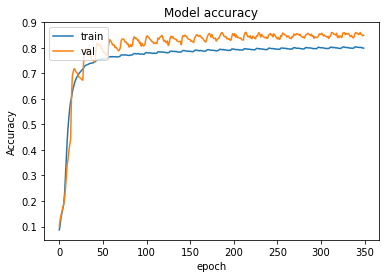

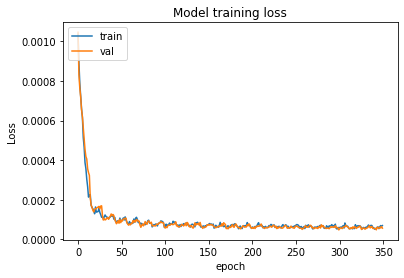

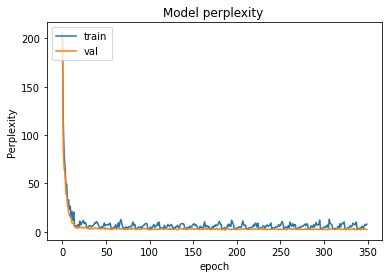

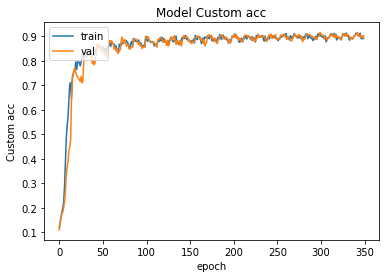

In [ ]:
if TRAIN_AND_SAVE_TRANFORMER:
    history_transformer = transformer.fit(dataset, epochs=epochs+50, shuffle= True,#6000
                            steps_per_epoch = train_size, callbacks=[PlotLossesCallback()], validation_data=val_dataset, validation_steps=10)
    transformer.save_weights("./checkpoints/transformer_ckpt")

    with open('./checkpoints/history_transformer.pickle', 'wb') as handle:
        pickle.dump(history_transformer.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Loading saved data ...")
    transformer = Transformer( num_layers=4, d_model=emb_dim, embeddings_matrix = embeddings_matrix, window_size = window_size, num_heads=10, dff=256, vocab_len=vocab_len, rate=0.1)
    transformer.load_weights("./checkpoints/transformer_ckpt")

    with open('./checkpoints/history_transformer.pickle', 'rb') as handle:
        history_transformer = pickle.load(handle)
        plt.figure()
        plt.plot(history_transformer['sparse_categorical_accuracy'])
        plt.plot(history_transformer['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['loss'])
        plt.plot(history_transformer['val_loss'])
        plt.title('Model training loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['perplexity'])
        plt.plot(history_transformer['val_perplexity'])
        plt.title('Model perplexity ')
        plt.ylabel('Perplexity')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.figure()
        plt.plot(history_transformer['custom_acc'])
        plt.plot(history_transformer['val_custom_acc'])
        plt.title('Model Custom acc')
        plt.ylabel('Custom acc')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

        plt.show()
 

In [ ]:
for i, o in val_dataset.take(1):
    print(i[0])
    print(' '.join([tokenizer.index_word[x.numpy()] for x in i[0] if x.numpy() != 0]))

tf.Tensor(
[11160     2    14     8 11161  3419     6  7605  4728    50    22   864
 11162     6   334  2545    23    46     6 11163    52   570   946    10
  1555   262  1541    65   326     2     6  3979  7606     2 11164     8
  1006    23   169  7607], shape=(40,), dtype=int32)
folios , com o craniosinho calvo de sabio curvado sobre as letras garrafais de boa doutrina : depois de crescidinho tinha tal proposito que permanecia horas imovel numa cadeira , de perninhas bambas , esfuracando o nariz : nunca apetecera


In [ ]:
input_sent = "<sos> no inverno , as familias necessitadas"

#tokenizer.texts_to_sequences("<sos> o rato roeu a roupa do rei de roma ")
#inp_seq = np.array([tokenizer.word_index[x] for x in input_sent.split()])

inp_seq = np.array([ w[0] for w in  tokenizer.texts_to_sequences(input_sent.split(" ")) if len(w)>0])
temp = 0.9
candidates_n = 50
max_len = 30

inp_seq#, tokenizer.word_index

array([    3,    26,   403,     2,    22,  5668, 10874])

# No Attention

In [ ]:
if GENERATE_TEXT:
    result1 = generate_sentence(model, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, no_state = False)
    result2 = generate_sentence(model, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)

    print("RESULT WITH STATE : ",result1["generated_text"],"\n")
    print("RESULT WITH STATE AND LOOP : ",result2["generated_text"],"\n")


RESULT WITH STATE :  <sos> no inverno , as familias necessitadas de toda a encontrar : o castro gomes parecia sabe ! , meu so , em nome de v . . . . e la quem e aquele e que 

RESULT WITH STATE AND LOOP :  <sos> no inverno , as familias necessitadas de toda a encontrar uma paixao que quasi nos servem , a proposito . e , com toda o seu ser . e a face de afonso . pelo que 



# Attention with causal mask on upper triangle

C:\Users\yanie\AppData\Local\Temp\ipykernel_19468\3519239606.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\yanie\AppData\Local\Temp\ipykernel_19468\3519239606.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 432x288 with 0 Axes>

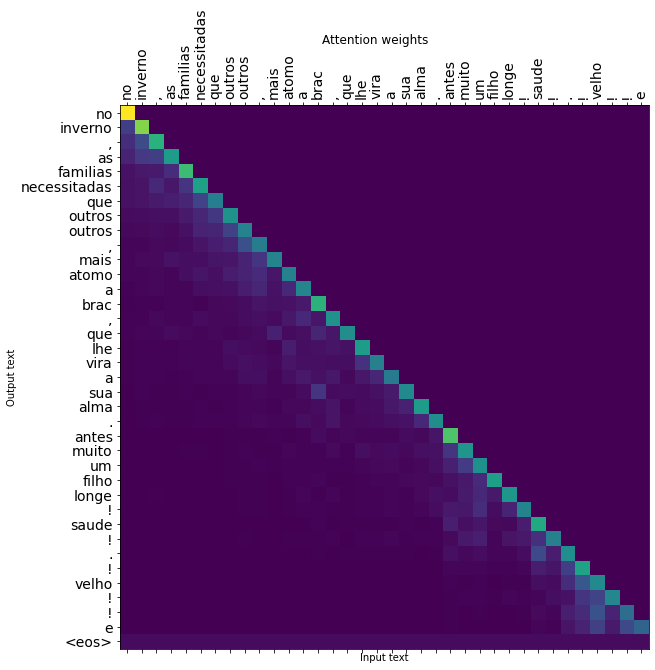

RESULT NO STATE :  <sos> no inverno , as familias necessitadas que outros outros , mais atomo a brac , que lhe vira a sua alma . antes muito um filho longe ! saude ! . ! velho ! ! e 

RESULT WITH STATE AND LOOP :  <sos> no inverno , as familias necessitadas que o poeta das imagens e os seus confortos sao . guardada e as senhoras de progresso e da unica : mas a vira ainda mais fraco de carlos , 



In [ ]:
if GENERATE_TEXT:
    result = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, no_state = True)
    result2 = generate_sentence(model_causal1, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)

    plot_weights(result, stop_time = 3, loop = False)
    print("RESULT NO STATE : ",result["generated_text"],"\n")
    print("RESULT WITH STATE AND LOOP : ",result2["generated_text"],"\n")


# Transformer with causal mask

RESULT  :  <sos> no inverno , as familias necessitadas distribuicoes de agasalhos e presidia no salao de arroios , com uma campainha , as reunioes em que se elaboravam os estatuto sao visitava os pobre sao ia tambem amiudadas 

RESULT WITH  LOOP :  <sos> no inverno , as familias necessitadas distribuicoes que o jardim da tribuna , com maria eduarda deixou escorregar do prazer romantico e para a sua declaracao , pendia para a rua de almofadas em que o 



C:\Users\yanie\AppData\Local\Temp\ipykernel_19468\3519239606.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\yanie\AppData\Local\Temp\ipykernel_19468\3519239606.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


<Figure size 432x288 with 0 Axes>

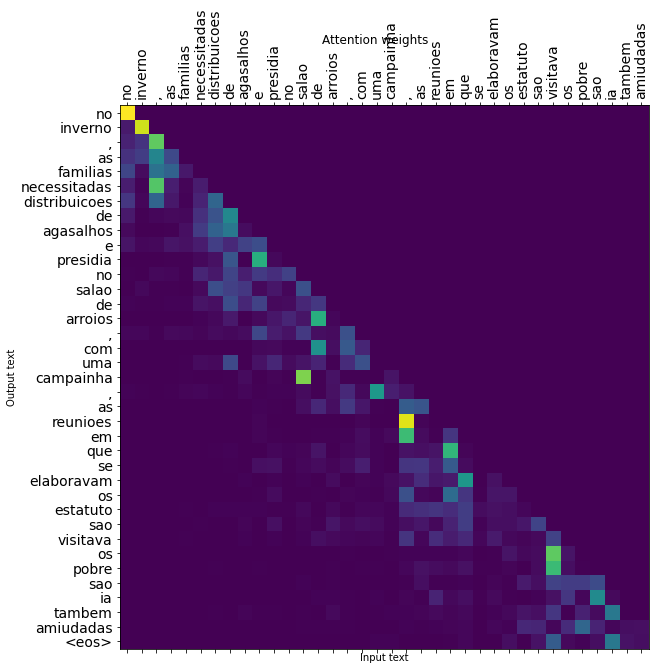

In [ ]:
if GENERATE_TEXT:
    result = generate_sentence_for_transformer(transformer, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n, )
    result1 = generate_sentence_for_transformer(transformer, input_tokens = tf.expand_dims(inp_seq,0), max_length= max_len, temperature= temp , number_of_candidates=candidates_n , loop= True)
    print("RESULT  : ",result["generated_text"],"\n")
    print("RESULT WITH  LOOP : ",result1["generated_text"],"\n")

    t = -1
    plt.figure()
    plot_attention(result['attention'][t]["decoder_layer4_block1"][0][-1],  result["output_text"][t],  result["output_text"][t])#input_text
    plt.show()

